In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [2]:
!pip install keras_cv -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 13.2 MB/s eta 0:00:00


In [3]:
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 12.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [4]:
!pip install segmentation_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.4 MB/s eta 0:00:00


In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import keras
from tensorflow.keras import ops
import keras_cv
import numpy as np
import segmentation_models as sm
from keras_cv.datasets.pascal_voc.segmentation import load as load_voc
from tensorflow.keras import backend as K

Segmentation Models: using `tf.keras` framework.


In [6]:
train_ds = load_voc(split="sbd_train")
eval_ds = load_voc(split="sbd_eval")

1419539633/1419539633 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


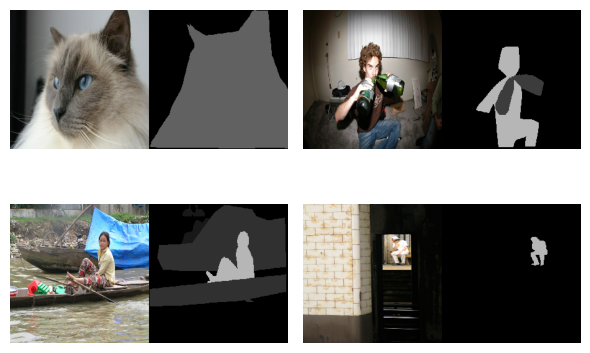

In [7]:
def preprocess_tfds_inputs(inputs):
    def unpackage_tfds_inputs(tfds_inputs):
        return {
            "images": tfds_inputs["image"],
            "segmentation_masks": tfds_inputs["class_segmentation"],
        }

    outputs = inputs.map(unpackage_tfds_inputs)
    outputs = outputs.map(keras_cv.layers.Resizing(height=224, width=224))
    outputs = outputs.batch(32, drop_remainder=True)
    return outputs


train_ds = preprocess_tfds_inputs(train_ds)
batch = train_ds.take(1).get_single_element()
keras_cv.visualization.plot_segmentation_mask_gallery(
    batch["images"],
    value_range=(0, 255),
    num_classes=21,
    y_true=batch["segmentation_masks"],
    scale=3,
    rows=2,
    cols=2,
)

In [8]:
eval_ds = preprocess_tfds_inputs(eval_ds)

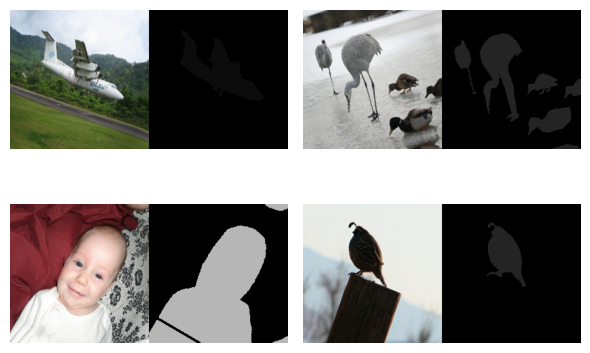

In [9]:
train_ds = train_ds.map(keras_cv.layers.RandomFlip())
train_ds = train_ds.map(keras_cv.layers.RandomRotation(factor=.1,segmentation_classes=21))

batch = train_ds.take(1).get_single_element()

keras_cv.visualization.plot_segmentation_mask_gallery(
    batch["images"],
    value_range=(0, 255),
    num_classes=21,
    y_true=batch["segmentation_masks"],
    scale=3,
    rows=2,
    cols=2,
)

In [10]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate
from tensorflow.keras.models import Model
def unet_model(input_size=(224,224, 3)):
    #build the model

    inputs = layers.Input(input_size)
    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(21, (1, 1), activation='softmax')(c9)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model


model = unet_model()


In [11]:
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [12]:
def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [13]:
metrics=['accuracy', jaccard_coef]
#compile the model
model.compile(
    optimizer='adam',
    loss=total_loss,
    metrics=metrics
)

In [14]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 56, 56, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 28, 28, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 28, 28, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 28, 28, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 14, 14, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 14, 14, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 14, 14, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 28, 28, 512)    │      2,097,664 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 28, 28, 1024)   │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 31,033,045 (118.38 MB)

 Trainable params: 31,033,045 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
def dict_to_tuple(x):


    return x["images"], tf.one_hot(
        tf.cast(tf.squeeze(x["segmentation_masks"], axis=-1), "int32"), 21
    )


train_ds = train_ds.map(dict_to_tuple)

eval_ds = eval_ds.map(dict_to_tuple)



In [16]:
model.fit(train_ds, validation_data=eval_ds, epochs=10 )

Epoch 1/10
    265/Unknown 817s 2s/step - accuracy: 0.6162 - jaccard_coef: 0.2978 - loss: 0.9762

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


265/265 ━━━━━━━━━━━━━━━━━━━━ 858s 3s/step - accuracy: 0.6163 - jaccard_coef: 0.2978 - loss: 0.9762 - val_accuracy: 0.6351 - val_jaccard_coef: 0.3477 - val_loss: 0.9493
Epoch 2/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 685s 3s/step - accuracy: 0.6276 - jaccard_coef: 0.3594 - loss: 0.9475 - val_accuracy: 0.5935 - val_jaccard_coef: 0.3531 - val_loss: 0.9394
Epoch 3/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 686s 3s/step - accuracy: 0.6083 - jaccard_coef: 0.3783 - loss: 0.9394 - val_accuracy: 0.5575 - val_jaccard_coef: 0.3466 - val_loss: 0.9414
Epoch 4/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 742s 3s/step - accuracy: 0.5905 - jaccard_coef: 0.3696 - loss: 0.9364 - val_accuracy: 0.6079 - val_jaccard_coef: 0.3964 - val_loss: 0.9263
Epoch 5/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 683s 3s/step - accuracy: 0.5993 - jaccard_coef: 0.3888 - loss: 0.9288 - val_accuracy: 0.6251 - val_jaccard_coef: 0.4265 - val_loss: 0.9321
Epoch 6/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 739s 3s/step - accuracy: 0.5937 - jaccard_coef: 0.3862 - loss: 0.9280 - val_

In [20]:
path = 'content/unetModel/my_model.h5'
model.save(path)

In [21]:
activation='softmax'

LR = 0.001
optim = keras.optimizers.Adam(LR)


dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)


In [22]:
BACKBONE1 = 'mobilenetv2'

n_classes=21
# define model
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)
model1.compile(optim, total_loss, metrics=metrics)
print(model1.summary())

/usr/local/lib/python3.10/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_pad (ZeroPadding2D) │ (None, None, None, 3)  │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, None, None, 32) │            864 │ Conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, None, None, 32) │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, None, None, 32) │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, None, None, 32) │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, None, None, 32) │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, None, None, 32) │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, None, None, 16) │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, None, None, 16) │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, None, None, 96) │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, None, None, 96) │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, None, None, 96) │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, None, None, 96) │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise    

 Total params: 8,050,341 (30.71 MB)

 Trainable params: 8,014,245 (30.57 MB)

 Non-trainable params: 36,096 (141.00 KB)

None


In [23]:
flag = True
for l in model1.layers:
  if l.name == 'decoder_stage0_upsampling':
    flag = False
  if flag:
    l.trainable = False

In [24]:
model1.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_pad (ZeroPadding2D) │ (None, None, None, 3)  │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, None, None, 32) │            864 │ Conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, None, None, 32) │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, None, None, 32) │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, None, None, 32) │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, None, None, 32) │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, None, None, 32) │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, None, None, 16) │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, None, None, 16) │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, None, None, 96) │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, None, None, 96) │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, None, None, 96) │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, None, None, 96) │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise    

 Total params: 8,050,341 (30.71 MB)

 Trainable params: 5,790,373 (22.09 MB)

 Non-trainable params: 2,259,968 (8.62 MB)

In [25]:
model1.fit(train_ds, validation_data=eval_ds, epochs=10, batch_size=32 )

Epoch 1/10
    265/Unknown 527s 2s/step - accuracy: 0.5472 - jaccard_coef: 0.2968 - loss: 0.9454

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


265/265 ━━━━━━━━━━━━━━━━━━━━ 561s 2s/step - accuracy: 0.5475 - jaccard_coef: 0.2971 - loss: 0.9453 - val_accuracy: 0.2489 - val_jaccard_coef: 0.1202 - val_loss: 1.0179
Epoch 2/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 523s 2s/step - accuracy: 0.6497 - jaccard_coef: 0.4196 - loss: 0.8864 - val_accuracy: 0.6183 - val_jaccard_coef: 0.4187 - val_loss: 0.8802
Epoch 3/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 505s 2s/step - accuracy: 0.6482 - jaccard_coef: 0.4365 - loss: 0.8631 - val_accuracy: 0.6469 - val_jaccard_coef: 0.4492 - val_loss: 0.8731
Epoch 4/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 526s 2s/step - accuracy: 0.6450 - jaccard_coef: 0.4472 - loss: 0.8425 - val_accuracy: 0.5737 - val_jaccard_coef: 0.3775 - val_loss: 0.8630
Epoch 5/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 498s 2s/step - accuracy: 0.6531 - jaccard_coef: 0.4624 - loss: 0.8291 - val_accuracy: 0.6725 - val_jaccard_coef: 0.4853 - val_loss: 0.8289
Epoch 6/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 498s 2s/step - accuracy: 0.6658 - jaccard_coef: 0.4771 - loss: 0.8174 - val_

In [26]:
#let all the layers be trained
for l in model1.layers:
    l.trainable = True

In [27]:
LR = 0.000005
optim = keras.optimizers.Adam(LR)

In [28]:
model1.compile(optim, total_loss, metrics=metrics)

In [ ]:
model1.fit(train_ds, validation_data=eval_ds, epochs=5, batch_size=32 )

Epoch 1/5
    224/Unknown 480s 2s/step - accuracy: 0.6454 - jaccard_coef: 0.4594 - loss: 0.8492